<a href="https://colab.research.google.com/github/dataeducator/BreastCancerVisualization/blob/main/ANN_Breast_Cancer_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Breast Cancer Diagnosis with ANN (PyTorch)
This notebook runs a PyTorch-based ANN on the UCI Breast Cancer dataset and evaluates performance over 30 seeds.

## 1. Install Dependencies

In [ ]:
!pip install torch torchvision scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.8 MB/s eta 0:00:00


## 2. Load and Scale Dataset

In [ ]:

import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

data = load_breast_cancer()
X = data.data
y = data.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## 3. Define PyTorch ANN Model and Train Function

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from scipy import stats

class BreastCancerANN(nn.Module):
    def __init__(self, input_dim):
        super(BreastCancerANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

def train_and_evaluate(seed, X_scaled, y):
    torch.manual_seed(seed)
    np.random.seed(seed)

    X_train, X_test, y_train_np, y_test_np = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=seed)
    y_train = torch.tensor(y_train_np, dtype=torch.float32).view(-1, 1)
    y_test = torch.tensor(y_test_np, dtype=torch.float32).view(-1, 1)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

    model = BreastCancerANN(X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).numpy()
        y_pred = (predictions > 0.5).astype(int)
        y_proba = predictions.ravel()

    tn, fp, fn, tp = confusion_matrix(y_test_np, y_pred).ravel()
    return {
        'Accuracy': accuracy_score(y_test_np, y_pred),
        'Precision': precision_score(y_test_np, y_pred),
        'Recall': recall_score(y_test_np, y_pred),
        'F1-Score': f1_score(y_test_np, y_pred),
        'AUC': roc_auc_score(y_test_np, y_proba),
        'Sensitivity': tp / (tp + fn),
        'Specificity': tn / (tn + fp)
    }

def ci(values):
    mean = np.mean(values)
    sem = stats.sem(values)
    margin = sem * stats.t.ppf((1 + 0.95) / 2., len(values)-1)
    return mean, mean - margin, mean + margin


## 4. Run 30 Evaluations and Summarize Metrics

In [ ]:

results = [train_and_evaluate(seed, X_scaled, y) for seed in range(30)]
df = pd.DataFrame(results)
ci_summary = {metric: ci(df[metric]) for metric in df.columns}
pd.DataFrame(ci_summary, index=['Mean', '95% CI Lower', '95% CI Upper']).T


,Mean,95% CI Lower,95% CI Upper
Accuracy,0.977485,0.971932,0.983039
Precision,0.978239,0.971900,0.984578
Recall,0.986574,0.981215,0.991933
F1-Score,0.982277,0.977923,0.986631
AUC,0.994257,0.992414,0.996100
Sensitivity,0.986574,0.981215,0.991933
Specificity,0.961905,0.950562,0.973247


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd
from scipy import stats

# Load and scale data
data = load_breast_cancer()
X = data.data
y = data.target
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the improved ANN
class OptimizedANN(nn.Module):
    def __init__(self, input_dim):
        super(OptimizedANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Confidence interval function
def ci(series):
    mean = series.mean()
    sem = stats.sem(series)
    margin = sem * stats.t.ppf((1 + 0.95) / 2., len(series)-1)
    return mean, mean - margin, mean + margin

# Training + evaluation function
def run_ann(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    X_train, X_test, y_train_np, y_test_np = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=seed)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).view(-1, 1)
    y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32).view(-1, 1)

    model = OptimizedANN(X.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step()

    model.eval()
    with torch.no_grad():
        y_pred_probs = model(X_test_tensor).numpy()
        y_pred = (y_pred_probs > 0.5).astype(int)
        y_proba = y_pred_probs.ravel()

    tn, fp, fn, tp = confusion_matrix(y_test_np, y_pred).ravel()
    return {
        'Accuracy': accuracy_score(y_test_np, y_pred),
        'Precision': precision_score(y_test_np, y_pred),
        'Recall': recall_score(y_test_np, y_pred),
        'F1-Score': f1_score(y_test_np, y_pred),
        'AUC': roc_auc_score(y_test_np, y_proba),
        'Sensitivity': tp / (tp + fn),
        'Specificity': tn / (tn + fp)
    }

# Run simulation over 30 seeds
results = [run_ann(seed) for seed in range(30)]
df_ann = pd.DataFrame(results)
ci_summary = {metric: ci(df_ann[metric]) for metric in df_ann.columns}
pd.DataFrame(ci_summary, index=["Mean", "95% CI Lower", "95% CI Upper"]).T


,Mean,95% CI Lower,95% CI Upper
Accuracy,0.973392,0.968196,0.978587
Precision,0.976668,0.971491,0.981845
Recall,0.981481,0.975811,0.987152
F1-Score,0.978979,0.974861,0.983098
AUC,0.994202,0.992354,0.996049
Sensitivity,0.981481,0.975811,0.987152
Specificity,0.959524,0.950436,0.968612


In [ ]:
!pip install torchviz graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

Accuracy: 0.9561
Precision: 0.9855
Recall: 0.9444
F1-Score: 0.9645
AUC: 0.9931
Sensitivity: 0.9444
Specificity: 0.9762


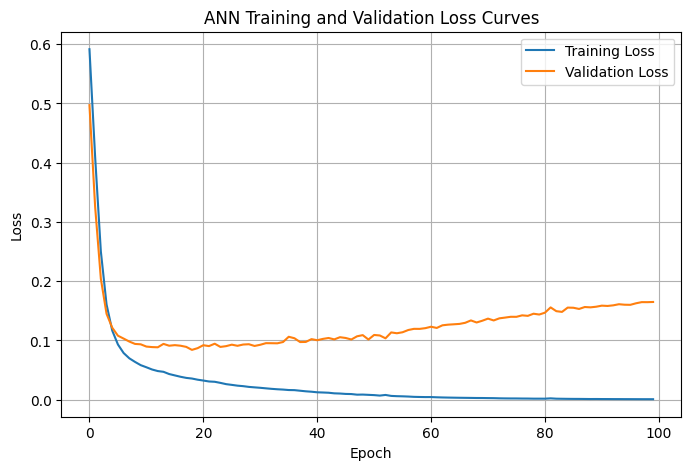

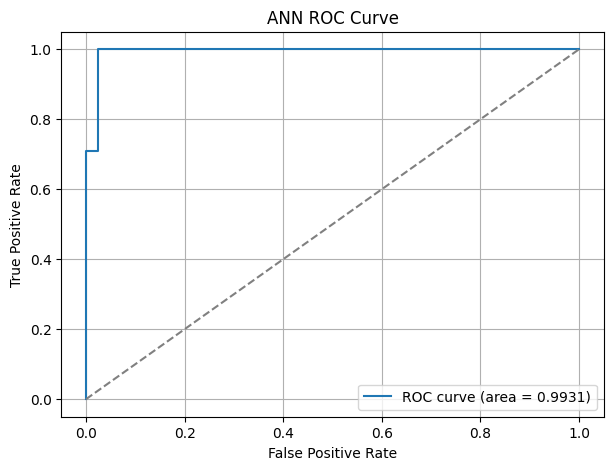

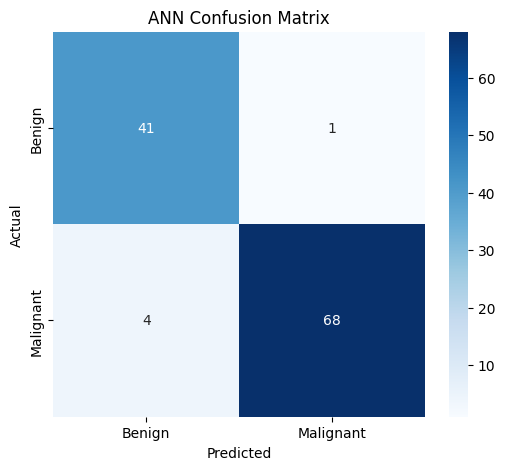

In [ ]:
!pip install torch torchvision scikit-learn --quiet
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

data = load_breast_cancer()
X = data.data
y = data.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from scipy import stats

class BreastCancerANN(nn.Module):
    def __init__(self, input_dim):
        super(BreastCancerANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

def train_and_evaluate(seed, X_scaled, y):
    torch.manual_seed(seed)
    np.random.seed(seed)

    X_train, X_test, y_train_np, y_test_np = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=seed)
    y_train = torch.tensor(y_train_np, dtype=torch.float32).view(-1, 1)
    y_test = torch.tensor(y_test_np, dtype=torch.float32).view(-1, 1)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

    model = BreastCancerANN(X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).numpy()
        y_pred = (predictions > 0.5).astype(int)
        y_proba = predictions.ravel()

    tn, fp, fn, tp = confusion_matrix(y_test_np, y_pred).ravel()
    return {
        'Accuracy': accuracy_score(y_test_np, y_pred),
        'Precision': precision_score(y_test_np, y_pred),
        'Recall': recall_score(y_test_np, y_pred),
        'F1-Score': f1_score(y_test_np, y_pred),
        'AUC': roc_auc_score(y_test_np, y_proba),
        'Sensitivity': tp / (tp + fn),
        'Specificity': tn / (tn + fp)
    }

def ci(values):
    mean = np.mean(values)
    sem = stats.sem(values)
    margin = sem * stats.t.ppf((1 + 0.95) / 2., len(values)-1)
    return mean, mean - margin, mean + margin

results = [train_and_evaluate(seed, X_scaled, y) for seed in range(30)]
df = pd.DataFrame(results)
ci_summary = {metric: ci(df[metric]) for metric in df.columns}
pd.DataFrame(ci_summary, index=['Mean', '95% CI Lower', '95% CI Upper']).T

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

# Plotting Training and Validation Loss Curves
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ANN Training and Validation Loss Curves')
plt.legend()
plt.grid()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.4f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ANN ROC Curve')
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix Visualization
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('ANN Confusion Matrix')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
)

# Load dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Preprocess
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Define hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 'scale'],
    'kernel': ['rbf']
}

# Grid search with cross-validation
grid = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

# Best model
best_svm = grid.best_estimator_

# Predictions
y_pred = best_svm.predict(X_test)
y_proba = best_svm.predict_proba(X_test)[:, 1]

# Confusion matrix components
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Evaluation metrics
results = {
    'Best Parameters': grid.best_params_,
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'AUC': roc_auc_score(y_test, y_proba),
    'Sensitivity': tp / (tp + fn),
    'Specificity': tn / (tn + fp),
    'Confusion Matrix': [[tn, fp], [fn, tp]]
}

# Print results
for k, v in results.items():
    print(f"{k}: {v}")

Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy: 0.9824561403508771
Precision: 0.9861111111111112
Recall: 0.9861111111111112
F1-Score: 0.9861111111111112
AUC: 0.998015873015873
Sensitivity: 0.9861111111111112
Specificity: 0.9761904761904762
Confusion Matrix: [[np.int64(41), np.int64(1)], [np.int64(1), np.int64(71)]]


Accuracy: 0.9561
Precision: 0.9855
Recall: 0.9444
F1-Score: 0.9645
AUC: 0.9931
Sensitivity: 0.9444
Specificity: 0.9762


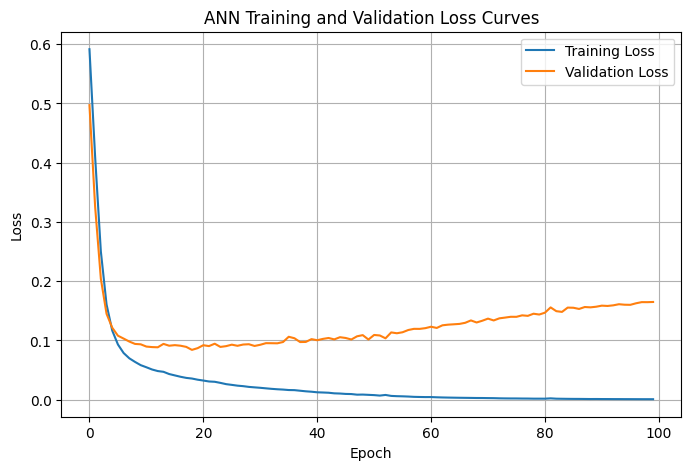

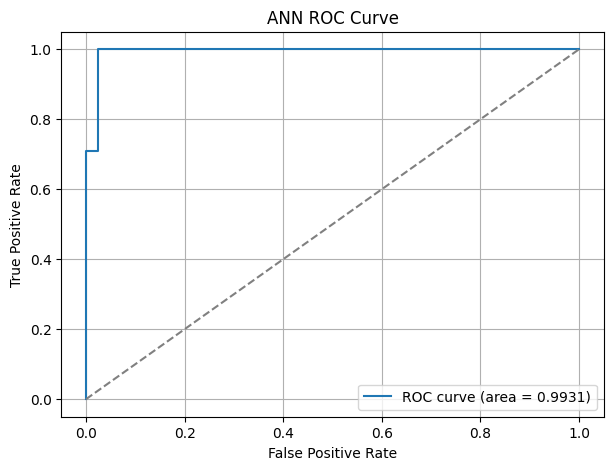

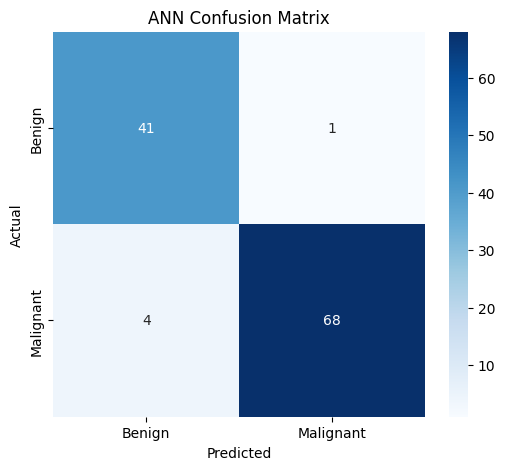

In [ ]:
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading and Scaling
data = load_breast_cancer()
X_scaled = StandardScaler().fit_transform(data.data)
y = data.target

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Tensor conversion
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train).view(-1, 1))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val).view(-1, 1))

# DataLoader with batch
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# ANN Model Definition
class BreastCancerANN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 1), nn.Sigmoid()
        )

    def forward(self, x): return self.model(x)

model = BreastCancerANN(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop with loss tracking
train_losses, val_losses = [], []
epochs = 100

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * len(X_batch)
    train_losses.append(epoch_train_loss / len(train_loader.dataset))

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_pred = model(val_dataset.tensors[0])
        val_loss = criterion(val_pred, val_dataset.tensors[1]).item()
        val_losses.append(val_loss)

# Predictions and Metrics
y_pred = (val_pred.numpy() > 0.5).astype(int)
y_proba = val_pred.numpy()

acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)
cm = confusion_matrix(y_val, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

# Plotting Training and Validation Loss Curves
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ANN Training and Validation Loss Curves')
plt.legend()
plt.grid()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.4f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ANN ROC Curve')
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix Visualization
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('ANN Confusion Matrix')
plt.show()